# Installs and Imports

## Basic Imports

In [1]:
%%capture
import os
import sys
import IPython
import torch
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import soundfile

## Vocoder Imports

In [2]:
%%capture
!pip install parallel_wavegan=='0.5.5'
!pip install h5py=='3.6.0'
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [3]:
from parallel_wavegan.utils import load_model
from parallel_wavegan.utils import read_hdf5
from parallel_wavegan.bin.preprocess import logmelfilterbank
import yaml

## TTS Imports

In [4]:
sys.path.insert(1, '/workspace/coqui-tts')
from TTS.config import load_config, register_config
from TTS.tts.models import setup_model
from TTS.tts.models.forward_tts import ForwardTTS
from TTS.tts.models.styleforward_tts import StyleforwardTTS
from TTS.utils.audio import AudioProcessor
from TTS.tts.utils.synthesis import synthesis
from TTS.tts.utils.speakers import SpeakerManager
from TTS.tts.utils.styles import StyleManager
from TTS.tts.utils.visual import plot_spectrogram

## UMAP Imports

In [5]:
%%capture
! pip install umap-learn
import umap
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Load Model and Set Device

In [6]:
%%capture

# MODEL AND DEVICE SELECTION
run_name = "pos"           
run_select = "last_checkpoint"
device = "cpu"
synthesizer = "hifi-gan" # hifi-gan or griffin-limm
use_cuda = True if device == "cuda" else False

# CHECKPOINTS
checkpoints_dict = {    
                    # Blizzard
                    "phonemes":{"last_checkpoint": "checkpoint_1140000.pth.tar", "part":"all"},
                    "chars":{"last_checkpoint": "checkpoint_1340000.pth.tar", "part":"all"},
                    "style":{"last_checkpoint": "checkpoint_1230000.pth.tar", "part":"all"},
                    "pos":{"last_checkpoint": "checkpoint_1260000.pth.tar", "part":"all"},
                    "pos_frozen_dec":{"last_checkpoint": "checkpoint_1240000.pth.tar", "part":"all"}
                    }

# EXPERIMENT FOLDER
folder = "../experiments/" + run_name + "/"

# LOAD CONFIG
config = load_config(folder + "config.json")

# LOAD SPEAKERS
if os.path.isfile(folder + "speakers.json"):
    spk_file_path = folder + "speakers.json"
    spk_manager = SpeakerManager(speaker_id_file_path = spk_file_path)
    with open(spk_file_path) as json_file:
        spk_to_id = json.load(json_file)
else:
    spk_to_id = {}
    spk_manager = None
    
# LOAD STYLES
if os.path.isfile(folder + "style_ids.json"):
    sty_file_path = folder + "style_ids.json"
    sty_manager = StyleManager(style_ids_file_path = sty_file_path)
    with open(sty_file_path) as json_file:
        sty_to_id = json.load(json_file)
else:
    sty_to_id = {}
    sty_manager = None
    
# LOAD MODEL        
model = setup_model(config, speaker_manager = spk_manager, style_manager = sty_manager)

# LOAD CHECKPOINT
checkpoint = torch.load(folder + checkpoints_dict[run_name][run_select], map_location=torch.device(device))['model']
model.load_state_dict(checkpoint)

# PREPARE MODEL
model.to(device)
model.eval()

# PREPARE VOCODER
if synthesizer != "griffin-limm":
    voc_name = synthesizer
    voc_checkpoint = "../experiments/vocoders/" + voc_name + "/checkpoint-470000steps.pkl"
    voc_config_path = "../experiments/vocoders/" + voc_name + "/config.yml"
    voc_stats = "../experiments/vocoders/" + voc_name + "/stats.h5"
    with open(voc_config_path) as f:
        voc_config = yaml.load(f, Loader = yaml.Loader)
    vocoder = load_model(voc_checkpoint, voc_config)
    vocoder.to(device)
    vocoder.eval()
    vocoder.remove_weight_norm()
    
    # CHECK COMPATIBILITY WITH TTS
    config.audio.log_func = 'np.log10'
    assert voc_config['sampling_rate'] == config.audio.sample_rate
    assert voc_config['fmax'] == config.audio.mel_fmax
    assert voc_config['fmin'] == config.audio.mel_fmin
    assert voc_config['fft_size'] == config.audio.fft_size
    assert voc_config['hop_size'] == config.audio.hop_length
    assert voc_config['win_length'] == config.audio.win_length
else:
    pass


# Audio Processor
ap = AudioProcessor(**config.audio)

# Audios

Outputs audios of the synthesis, ressynthesis and ground-truths.

## Synthesis

In [7]:
def read_test_metadata(subset):
    # Get csv
    df = pd.read_csv("../recipes/blizzard_2023/blizzard_2023/2023-FH1_submission_directory/" + subset + "/" + subset + ".csv", sep = "\n", header=None)
    lines = [item for sublist in df.values.tolist() for item in sublist]
    # Parse csv
    file_names = []
    texts = []
    for line in lines:
        file_names.append(line.split(sep='|')[0])
        texts.append(line.split(sep='|')[1])
    return {'texts':texts, 'names':file_names}

In [8]:
def synthesize_test_metadata(subset, save):
    info = read_test_metadata(subset)
    
    for idx in tqdm(range(len(info['texts']))):
        
        # TEXT
        text = info['texts'][idx]
        
        # SYNTHESIS
        if synthesizer == "griffin-limm":
            out = synthesis(use_griffin_lim=True, text = text, model = model, CONFIG = config, use_cuda = use_cuda, ap = ap)
        else:
            fp_out = synthesis(text = text, model = model, CONFIG = config, use_cuda = use_cuda, ap = ap)
            feat_gen_denorm = torch.Tensor(fp_out['outputs']['model_outputs'].cpu().numpy()[0]).cuda()
            feat_gen_denorm = torch.log10(torch.exp(feat_gen_denorm))
            feat_gen_norm = (feat_gen_denorm.cpu() - torch.from_numpy(read_hdf5(voc_stats, "mean"))) / torch.from_numpy(read_hdf5(voc_stats, "scale"))
            out = {'wav':vocoder.inference(feat_gen_norm).cpu().detach().numpy().squeeze(1)}
        audio_syn = out['wav']
        
        # Save
        if save:
            soundfile.write("../recipes/blizzard_2023/blizzard_2023/2023-FH1_submission_directory/" + subset + "/wav/" + info['names'][idx] + ".wav", audio_syn, config.audio.sample_rate, "PCM_16")
        
    return None    

In [12]:
idx = 51
text = read_test_metadata("NEB_test")['texts'][idx]

# text = ".Je plaide le crétinisme, l'irresponsabilité, et je réclame l'acquittement! Vous savez où est mon maïs?"
text = ".un petit croisillon de fils d'or, en manière de gland."

# SYNTHESIS
if synthesizer == "griffin-limm":
    out = synthesis(use_griffin_lim=True, text = text, model = model, CONFIG = config, use_cuda = use_cuda, ap = ap)
else:
    fp_out = synthesis(text = text, model = model, CONFIG = config, use_cuda = use_cuda, ap = ap)
    feat_gen_denorm = torch.Tensor(fp_out['outputs']['model_outputs'].cpu().numpy()[0]).cuda()
    feat_gen_denorm = torch.log10(torch.exp(feat_gen_denorm))
    feat_gen_norm = (feat_gen_denorm.cpu() - torch.from_numpy(read_hdf5(voc_stats, "mean"))) / torch.from_numpy(read_hdf5(voc_stats, "scale"))
    out = {'wav':vocoder.inference(feat_gen_norm).cpu().detach().numpy().squeeze(1)}

# RESULTS
audio_syn = out['wav']

print("Text = {}".format(text))
#print("Spk = {}".format(speaker))
#print("Sty = {}".format(style))
#print("Sty_Wav = {}".format(style_wav))
#print("Sty_Rep = {}".format(style_representation))
IPython.display.Audio(audio_syn, rate=config.audio.sample_rate)

cpu
cpu
Text = .un petit croisillon de fils d'or, en manière de gland.


In [10]:
model.pos.model.to('cpu')

CamembertForTokenClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0): CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [10]:
device

'cpu'

## GT Resynthesis

In [19]:
idx = 1
wavs_path = '../recipes/blizzard_2023/blizzard_2023/wavs/'
wav_path = wavs_path + os.listdir(wavs_path)[idx]
gt_wav = ap.load_wav(wav_path)
gt_spectrogram = ap.melspectrogram(gt_wav)

if synthesizer == 'griffin-limm':
    res_wav = ap.inv_melspectrogram(gt_spectrogram)
else:
    feat_gen_denorm = torch.Tensor(gt_spectrogram.T).cuda()
    feat_gen_norm = (feat_gen_denorm.cpu() - torch.from_numpy(read_hdf5(voc_stats, "mean"))) / torch.from_numpy(read_hdf5(voc_stats, "scale"))
    res_wav = vocoder.inference(feat_gen_norm).cpu().detach().numpy().squeeze(1)
res_spectrogram = ap.melspectrogram(res_wav)

# PLAY GT+RES
IPython.display.Audio(res_wav, rate=config.audio.sample_rate)

## GT

In [17]:
gt_wav = ap.load_wav(wav_path)
IPython.display.Audio(gt_wav, rate=config.audio.sample_rate)

# Mel-Spectrograms

Outputs images of mel-spectrograms.

## Synthesis

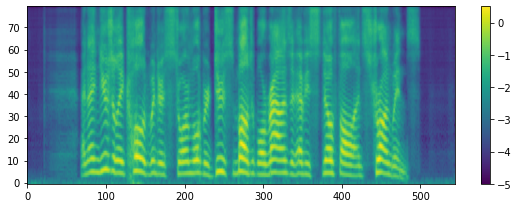

In [334]:
# PLOT GT MEL-SPECTROGRAM
plot_spectrogram(ap.melspectrogram(audio_syn).T, ap, fig_size=(8,3))

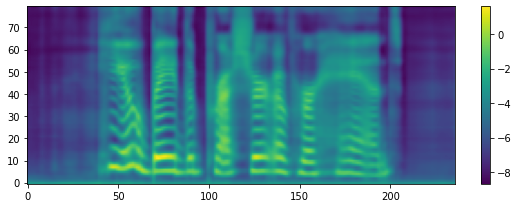

In [14]:
plot_spectrogram(fp_out['outputs']['model_outputs'].cpu().numpy()[0], ap, fig_size=(8,3))

## GT Resynthesis

In [ ]:
# PLOT GT+RES MEL-SPECTROGRAM
plot_spectrogram(res_spectrogram.T, ap, fig_size=(8,3))

## GT

In [ ]:
# PLOT GT MEL-SPECTROGRAM
plot_spectrogram(gt_spectrogram.T, ap, fig_size=(8,3))

# UMAP

Outputs style spaces and style representations.

## Setup

In [ ]:
from TTS.trainer import Trainer, TrainingArgs
from TTS.tts.datasets import load_tts_samples

In [333]:
#### DATASET DEFINITIONS ####

config.datasets[0].path = '../recipes/blizzard_2023/blizzard_2023'
test = '../recipes/blizzard_2023/blizzard_2023/metadata/metadata_neb_train.csv'
test = pd.read_csv(test, delimiter='|', encoding= 'utf-8', header=None, names = ['wav_path', 'text', 'speaker']) 

rows_wrong = []
for i in range(len(test)):
    text = test.iloc[i].text
    if len(text) > 500:
        rows_wrong.append(i)
test.drop(rows_wrong, inplace=True)
#### TRAINER ####

# init trainer args
train_args = TrainingArgs()

# load training samples
train_samples, eval_samples = load_tts_samples(config.datasets, eval_split=True)

# init speaker manager
if config.use_speaker_embedding:
    speaker_manager = SpeakerManager(data_items=train_samples + eval_samples)
elif config.use_d_vector_file:
    speaker_manager = SpeakerManager(d_vectors_file_path=config.d_vector_file)
else:
    speaker_manager = None

# init style manager
if config.style_encoder_config.use_supervised_style:
    style_manager = StyleManager(data_items=train_samples + eval_samples)
    if hasattr(config, "model_args"):
        config.model_args.num_styles = style_manager.num_styles
    else:
        config.num_styles = style_manager.num_styles
else:
    style_manager = None
    
# init the model from config
language_manager = None
model = setup_model(config, speaker_manager, language_manager, style_manager)

# init the trainer
trainer = Trainer(
    train_args,
    config,
    config.output_path,
    model=model,
    train_samples=train_samples,
    eval_samples=eval_samples,
    training_assets={"audio_processor": ap},
    parse_command_line_args=False,
)

# restore checkpoint
checkpoint = folder + checkpoints_dict[run_name]['last_checkpoint']
trainer.model, opt, scaler, restore_step = trainer.restore_model(config, checkpoint, trainer.model, trainer.optimizer, trainer.scaler)

# extract representations
use_cuda = True

N = config['style_encoder_config']['style_embedding_dim']

syn_embs = np.zeros((len(test), N))
wavs = []

for i in tqdm(range(len(test))):
    
    # Model Inputs
    test = test.sample(frac=1).reset_index(drop=True)
    text = test.text.values[i]
    speaker = test.speaker.values[i]
    style_wav = '../recipes/blizzard_2023/blizzard_2023/wavs/' + test.wav_path.values[i]

    # Embeddings for synthesis
    fp_out = synthesis(text = text, style_wav=style_wav, model = model, CONFIG = config, use_cuda = use_cuda, ap = ap)
    syn_embs[i] = fp_out['outputs']['style_encoder_outputs']['style_embedding'].squeeze(0).squeeze(0).detach().cpu().numpy()
    
    # Save Info
    wavs.append(style_wav)

  0%|                                                                                              | 9/62061 [00:01<3:27:01,  5.00it/s]


KeyboardInterrupt: 

## Style Space

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


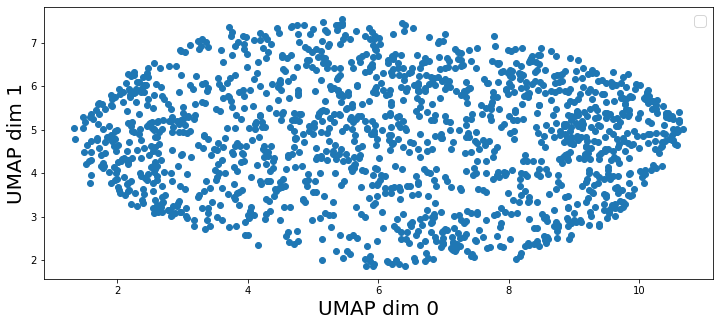

In [329]:
# FIT / TRANSFORM UMAP
#u = umap.UMAP(random_state = 42)
#embeddings = u.fit_transform(syn_embs)
embeddings = u.transform(syn_embs[np.array(quotes_idxs),:])

# Creating dataframe to better manipulate
df = pd.DataFrame({'dim1': embeddings[:,0], 'dim2': embeddings[:,1]})

# Plot
%matplotlib inline
plt.figure(figsize=(12,5))
plt.scatter(df['dim1'], df['dim2'])
plt.legend(fontsize=15)
plt.xlabel('UMAP dim 0', fontsize = 20)
plt.ylabel('UMAP dim 1', fontsize = 20)
plt.show()

In [16]:
with open('syn_embeddings_blizzard.npy', 'wb') as f:
    np.save(f, syn_embs)

## Extract Centroid Representation

In [10]:
style_representations = syn_embs
centroid = style_representations.mean(axis=0)

In [11]:
u.transform(centroid.reshape(1,-1))

array([[5.6100388, 4.522378 ]], dtype=float32)

In [88]:
def find_topk(reference_idx, k):
    dists = []
    reference = np.array([df.iloc[reference_idx].dim1, df.iloc[reference_idx].dim2])
    for i in tqdm(range(len(df))):
        point = np.array([df.iloc[i].dim1, df.iloc[i].dim2])
        dists.append(np.sqrt(np.power(reference[0]-point[0], 2) + np.power(reference[1]-point[1], 2)))
    top_k_idxs = np.argpartition(-np.array(dists), -k)[-k:]
    return top_k_idxs

In [184]:
df[df['dim2'].between(5.144180,5.145)].sort_values(by='dim1')

,dim1,dim2
38324,1.617962,5.144266
20949,1.787235,5.144690
9181,1.921585,5.144662
59536,3.575769,5.144694
20435,3.895063,5.144828
52084,4.180489,5.144289
50646,4.342306,5.144451
53034,5.045415,5.144493
56709,5.063077,5.144876
46089,6.244248,5.144834


In [227]:
find_topk(53034, 10)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 62061/62061 [00:12<00:00, 4822.25it/s]


array([33868, 21101,   662, 40828, 56709, 17638, 41248, 14505, 53034,
       33197])

In [274]:
wav = wavs[6]
wav

'../recipes/blizzard_2023/blizzard_2023/wavs/FL_MB_NEB_03_0011__1144518.wav'

In [275]:
test[test['wav_path'] == wav.split('/')[-1]] 

,wav_path,text,speaker
59162,FL_MB_NEB_03_0011__1144518.wav,",et Charles suffoquait comme un adolescent sou...",NEB


In [315]:
quotes_idxs = []
for idx in tqdm(range(len(wavs))):
        if test[test['wav_path'] == wavs[idx].split('/')[-1]].text.item().find('«') != (-1):
            quotes_idxs.append(idx)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 62061/62061 [12:05<00:00, 85.50it/s]


In [311]:
quotes_idxs = []
if test[test['wav_path'] == wavs[8].split('/')[-1]].text.item().find('«') != (-1):
    quotes_idxs.append(8)

In [316]:
quotes_idxs

[8,
 48,
 60,
 82,
 106,
 153,
 163,
 255,
 283,
 300,
 320,
 339,
 398,
 449,
 557,
 564,
 585,
 649,
 740,
 766,
 774,
 805,
 846,
 956,
 970,
 982,
 1029,
 1078,
 1108,
 1114,
 1156,
 1203,
 1230,
 1467,
 1481,
 1523,
 1533,
 1550,
 1566,
 1588,
 1701,
 1716,
 1771,
 1783,
 1884,
 1886,
 1898,
 1946,
 2005,
 2130,
 2132,
 2255,
 2332,
 2425,
 2513,
 2525,
 2535,
 2559,
 2562,
 2614,
 2641,
 2848,
 3001,
 3070,
 3078,
 3096,
 3097,
 3114,
 3166,
 3213,
 3237,
 3306,
 3308,
 3369,
 3462,
 3478,
 3554,
 3652,
 3660,
 3718,
 3747,
 3758,
 3801,
 3825,
 3827,
 3868,
 3923,
 3927,
 3991,
 4038,
 4091,
 4194,
 4220,
 4266,
 4282,
 4327,
 4377,
 4379,
 4506,
 4511,
 4567,
 4628,
 4638,
 4693,
 4740,
 4766,
 4836,
 4893,
 4927,
 5027,
 5029,
 5032,
 5054,
 5067,
 5110,
 5115,
 5120,
 5159,
 5217,
 5219,
 5281,
 5298,
 5322,
 5340,
 5341,
 5352,
 5379,
 5416,
 5437,
 5445,
 5489,
 5509,
 5516,
 5547,
 5621,
 5651,
 5656,
 5743,
 5777,
 5789,
 5826,
 5854,
 5884,
 5887,
 5907,
 5923,
 5982,
 6

In [319]:
a = syn_embeddings[np.array(quotes_idxs)]

array([5, 2, 3])

(1501, 384)

In [7]:
def read_metadata(dataset, sub):
    # Get csv
    df = pd.read_csv("../recipes/emovdb/emovdb/" + "metadata/metadata_"+ dataset + "_" + sub + ".csv", sep = "\n", header=None)
    lines = [item for sublist in df.values.tolist() for item in sublist]
    if 'lj' in run_name:
        if dataset == 'test':
            dataset = 'val'
        df_lj = pd.read_csv("../recipes/ljspeech/LJSpeech-1.1/" + "metadata/metadata_" + dataset + "_reduced.csv", sep = "\n", header=None)
        lines_lj = [item for sublist in df_lj.values.tolist() for item in sublist]
    # Parse csv
    file_names = []
    texts = []
    spks = []
    styles = []
    for line in lines:
        file_names.append('../recipes/emovdb/emovdb/files/'+ line.split(sep='|')[0])
        texts.append(line.split(sep='|')[1])
        spks.append(line.split(sep='|')[2])
        styles.append(line.split(sep='|')[3])
    if 'lj' in run_name:
        for line in lines_lj:
            file_names.append('../recipes/ljspeech/LJSpeech-1.1/wavs/'+ line.split(sep='|')[0] + '.wav')
            texts.append(line.split(sep='|')[1])
            spks.append('ljspeech')
            styles.append('Neutral')
    return {'texts':texts, 'speakers':spks, 'styles':styles, 'style_wavs':file_names}